# Linear Transformer Decoder on 5G LDPC codes.

This note book walks you through the code on how to run the decoder.

In [ ]:
# Imports
import tensorflow as tf
import random
import numpy as np
import time
import os

from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder

In [ ]:
# Checking GPUs are recognized
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## 5G LDPC Code
Here we specify code parameters such as `k` and `n`, instantiate the `LDPC5GEncoder` and `LDPC5GDecoder`, prune the `parity-check matrix` and check that `syndorme = 0` for non-rate matching scenario.

In [3]:
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.utils import LinearEncoder
from src.utils5G import generate_pruned_pcm_5g


k = 35
n = 70
rate_matching = True

encoder_5g = LDPC5GEncoder(k, n, dtype=tf.int32)
decoder_5g = LDPC5GDecoder(encoder_5g,
                            num_iter=1, # BP iterations
                            return_infobits=False,
                            prune_pcm=True
                            )
pcm, rm_pattern = generate_pruned_pcm_5g(decoder_5g, n)

# create encoder without rate-matching
u_ref = tf.cast(np.eye(k), dtype=tf.int32)
c_ref = encoder_5g(u_ref).numpy()


gm = np.concatenate([u_ref[:,:2*encoder_5g._z], c_ref], axis=1)
encoder_no_rm = LinearEncoder(gm, is_pcm=False, dtype=tf.int32)

# syndrome check
if not rate_matching:
    b = tf.floor(tf.random.uniform((1, k), minval=0, maxval=2))
    b = tf.cast(b, tf.int32)
    c = encoder(b)
    print(pcm @ tf.transpose(c) % 2)

# Encoder for 5G NR
encoder = encoder_5g if rate_matching else encoder_no_rm

2025-01-19 11:05:23.573485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Note: decoder uses tf.float32 for internal calculations.
using bg:  bg2
# information bits: 35
CW length after rate-matching: 70
CW length without rm (incl. first 2*Z info bits): 82
# punctured bits: 205
# pruned nodes: 205
# parity bits 47
# shortened bits 25
pruned pcm dimension: (47, 82)


2025-01-19 11:05:23.573621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-19 11:05:23.573666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-19 11:05:23.576715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Training and optimal hyperparameters for Regular Transformer
Here we set training parameters and have a for loop for testing optimal model hyperparameters.

In [ ]:
from src.args import Args
from src.decoder5G import Decoder5G, Decoder
from src.e2e_model import E2EModel

from src.utils import train_dec
import gc


# args for decoder
linear = False
args = Args()
# training
args.lr = 3e-5
args.batch_size = 100
args.ebno_db_min = 0 # training with higher ebno db leads to better quicker results
args.ebno_db_max = 8
args.epochs = 1200000

args.code.H = pcm
m_pcm, n_pcm = pcm.shape

# Loop for testing optimal hyperparams
for t_layers in [6]:
    for d_model in [128]:
        args.t_layers = t_layers
        args.d_model = d_model

        # Regular Transformer 5G Decoder (LTD) 
        transformer_decoder5G = Decoder5G( encoder_5g, args, linear=linear, verbose=False) \
                                if rate_matching else Decoder(args, linear=linear,)
        # no rate matching sizes, else the specified k,n to the encoder
        if not rate_matching:
            m, n = pcm.shape
            k = n-m
        # Initialize model
        e2e_5G = E2EModel(encoder, transformer_decoder5G, k, n, rate_matching=rate_matching)

        # get best weights function
        file_name = f'ECCT_pcm_{m_pcm}_{n_pcm}_Tlayers{t_layers}_dims{d_model}/weights' # 'weights' is not a file just a place holder

        train_dec(e2e_5G,
                    args,
                    file_name=file_name,
                    load_decoder_weights=True,
                    )
        
        del e2e_5G # Delete model to free up space and prevent kernel crash
        gc.collect()      

## Plotting performance
Here we use Sionna's  `PlotBER` to evaluate performance and compare against Belief Propagation decoding.

Best loss_value found: 0.11922
Successfully restored weights from ./Decoder_weights/ECC_weights/ECCT_pcm_47_82_Tlayers6_dims128/best_weights_loss_value_1.19220e-01-1
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 1.0531e-01 | 1.0000e+00 |        3686 |       35000 |          500 |         500 |         0.7 |reached target block errors
      3.0 | 7.7262e-02 | 9.9500e-01 |        3245 |       42000 |          597 |         600 |         0.1 |reached target block errors
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 1.0703e-01 | 1.0000e+00 |        3746 | 

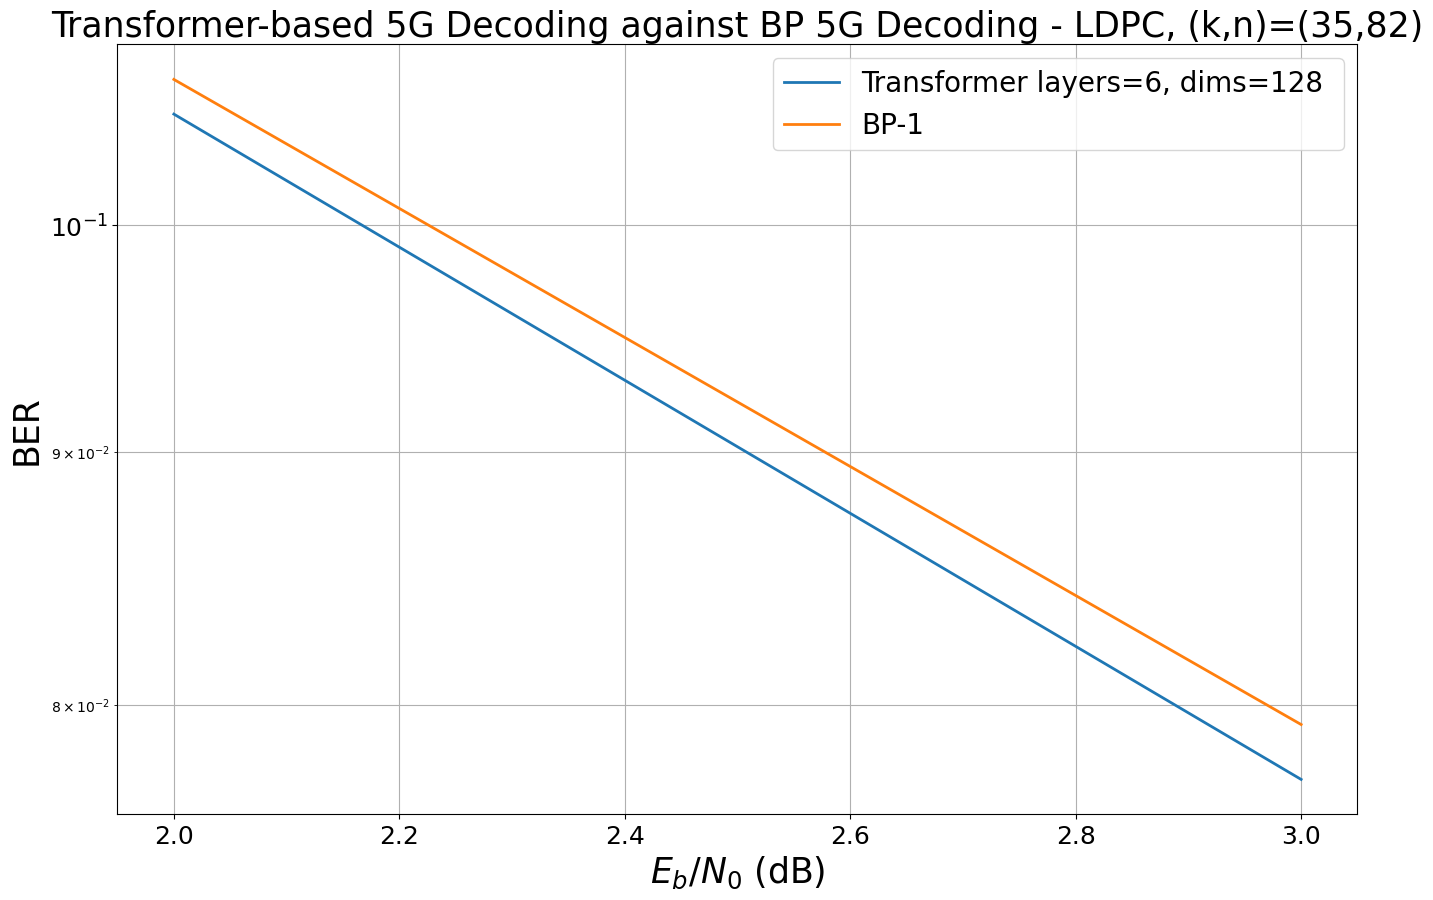

In [23]:
from src.utils import load_weights, parse_best_loss_value_from_filename


# simulation args
linear = False
args.mc_batch_size = 100
args.mc_iters = 1000000

args.ebno_db_min = 2
args.ebno_db_max = 4
args.ebno_db_stepsize = 1

m_pcm, n_pcm = pcm.shape
k_pcm = n_pcm-m_pcm
ber_plot = PlotBER(f"Transformer-based 5G Decoding against BP 5G Decoding - LDPC, (k,n)=({k_pcm},{n_pcm})")
ebno_dbs = np.arange(args.ebno_db_min,
                     args.ebno_db_max,
                     args.ebno_db_stepsize)

# Loop to test optimal hyperparameters
for t_layers in [6]:
    for d_model in [128]:
        args.t_layers = t_layers
        args.d_model = d_model

        # Regular Transformer 5G Decoder    
        transformer_decoder5G = Decoder5G( encoder_5g, args, linear=linear, verbose=False ) \
                                if rate_matching else Decoder(args, linear=linear,)

        # Initialize model
        e2e_5G = E2EModel(encoder, transformer_decoder5G, k, n, rate_matching=rate_matching)

        # Load model weights
        dir_path = f"./Decoder_weights/ECC_weights/ECCT_pcm_{m_pcm}_{n_pcm}_Tlayers{t_layers}_dims{d_model}/"
        _, best_file = parse_best_loss_value_from_filename(dir_path)
        best_weights_path = os.path.join(dir_path, best_file)

        load_weights(e2e_5G, best_weights_path)

        # and run the BER simulations
        ber_plot.simulate(e2e_5G,
                        ebno_dbs=ebno_dbs,
                        batch_size=args.mc_batch_size,
                        num_target_block_errors=500,
                        legend=f"Transformer layers={e2e_5G._decoder.t_layers}, dims={e2e_5G._decoder.dims} ",
                        soft_estimates=False,
                        max_mc_iter=args.mc_iters,
                        forward_keyboard_interrupt=False,
                        show_fig=False);

# Finally compare against 5G BP decoding
e2e_bp = E2EModel(encoder_5g,
                  decoder_5g,
                  k,
                  n,
                  rate_matching=True)

ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=args.mc_batch_size,
                  num_target_block_errors=500,
                  legend=f"BP-{decoder_5g._num_iter.numpy()}",
                  soft_estimates=True,
                  max_mc_iter=args.mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=True);

## Training and optimal hyperparameters for Linear Transformer
Here we set training parameters, we have a for loop for testing optimal model hyperparameters and another inner loop for mask divisions.

In [ ]:
from src.utils import train_dec
import gc

# optimal hyperparameters
args = Args()
linear = True 

args.lr = 3e-5
args.batch_size = 100
args.ebno_db_min = 0 # training with higher ebno db leads to better quicker results
args.ebno_db_max = 8
args.epochs = 3000000
m_pcm, n_pcm = pcm.shape
k_pcm = n_pcm-m_pcm

# Loop for testing optimal hyperparams
for t_layers in [8]:
    for d_model in [64]:
        # Model args
        args.t_layers = t_layers
        args.d_model = d_model

        # mask shape divided by mask_div on one dimention, the computes gcd for k_proj shape
        for mask_div in range(2, 3): 
            args.mask_division_shape = mask_div

            # Linear Transformer 5G Decoder (LTD)
            lin_transformer_decoder5G = Decoder5G( encoder_5g, args, linear=linear, verbose=False) \
                                    if rate_matching else Decoder(args, linear=linear,)
            # no rate matching sizes, else the specified k,n to the encoder
            if not rate_matching:
                m, n = pcm.shape
                k = n-m
            # Initialize model
            e2e_5G = E2EModel(encoder, lin_transformer_decoder5G, k, n, rate_matching=rate_matching)

            # get best weights function
            file_name = f'LECCT_maskdiv{mask_div}_pcm_{m_pcm}_{n_pcm}_Tlayers{args.t_layers}_dims{args.d_model}/weights' # 'weights' is not a file just a place holder

            train_dec(e2e_5G,
                    args,
                    file_name=file_name,
                    load_decoder_weights=True,)
            
            del e2e_5G # Delete model to free up space and prevent kernel crash
            gc.collect()      

# Comparing all decoders
Finally we compare performance of the Tranformer, Linear Transformer and Belief Propagation.

Best loss_value found: 0.131151
./Decoder_weights/ECC_weights/LECCT_maskdiv2_pcm_47_82_Tlayers8_dims64 best_weights_loss_value_1.31151e-01-1
Successfully restored weights from ./Decoder_weights/ECC_weights/LECCT_maskdiv2_pcm_47_82_Tlayers8_dims64/best_weights_loss_value_1.31151e-01-1
Training Model...
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 1.0291e-01 | 1.0000e+00 |        3602 |       35000 |          500 |         500 |         0.5 |reached target block errors
      3.0 | 7.8286e-02 | 9.9500e-01 |        3288 |       42000 |          597 |         600 |         0.0 |reached target block errors
      4.0 | 5.5881e-02 | 9.8667e-01 |        2347 |       42000 |          592 |         600 |         0.0 |reached target block errors
Best loss_value found: 0.11922
Suc

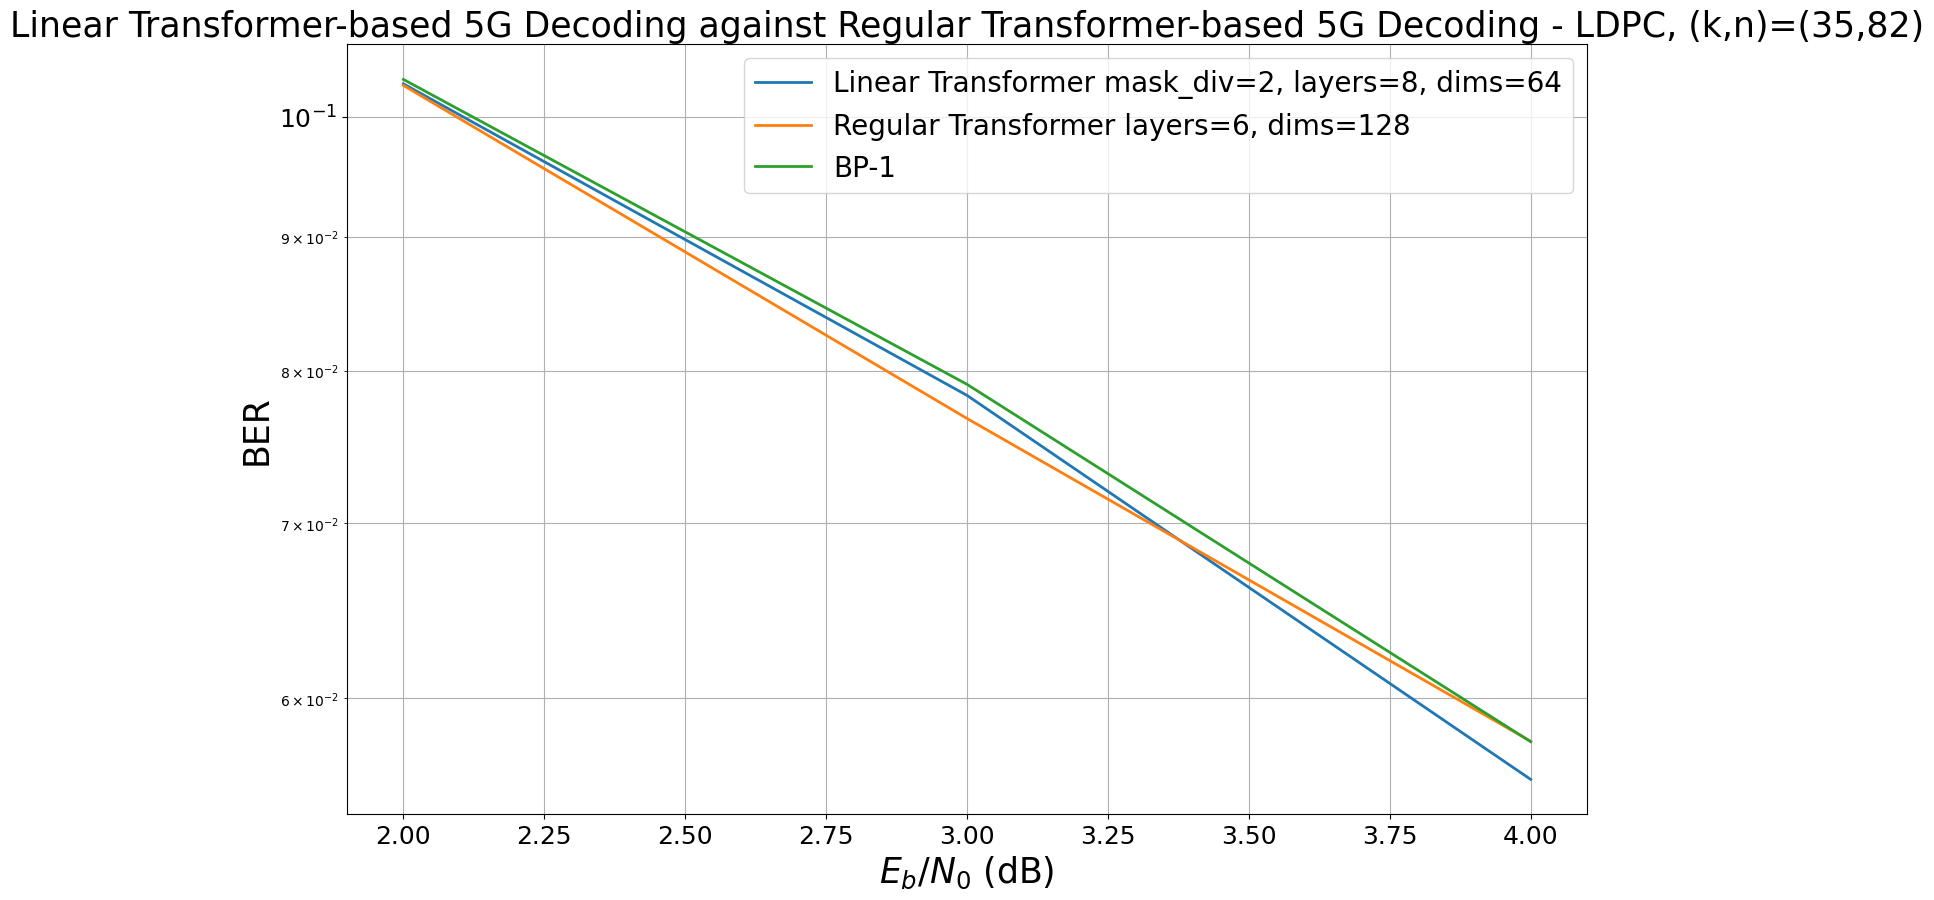

In [22]:
from src.utils import *

# Speed to BER trade off graph
ber_plot = PlotBER(f"Linear Transformer-based 5G Decoding against Regular Transformer-based 5G Decoding - LDPC, (k,n)=({k_pcm},{n_pcm})")
args.mc_batch_size = 100
args.mc_iters = 1000000

args.ebno_db_min = 2
args.ebno_db_max = 5
args.ebno_db_stepsize = 1

ebno_dbs = np.arange(args.ebno_db_min,
                     args.ebno_db_max,
                     args.ebno_db_stepsize)

# Loop for testing optimal hyperparams
for t_layers in [8]:
    for d_model in [64]:
        # Model args
        args.t_layers = t_layers
        args.d_model = d_model
        
        # mask shape divided by mask_div on one dimention, the computes gcd for k_proj shape
        for mask_div in range(2,3):
                args.mask_division_shape = mask_div
                
                # Linear Transformer 5G Decoder (LTD) 
                lin_transformer_decoder5G = Decoder5G( encoder_5g, args, linear=linear, verbose=False ) \
                                        if rate_matching else Decoder(args, linear=linear,)

                # Initialize model
                e2e_5G = E2EModel(encoder, lin_transformer_decoder5G, k, n, rate_matching=rate_matching)

                 # Load model weights
                file_name = f'LECCT_maskdiv{mask_div}_pcm_{m_pcm}_{n_pcm}_Tlayers{args.t_layers}_dims{args.d_model}/weights' # 'weights' is not a file just a place holder
                # Initializing model
                args.epochs = 1
                train_dec(e2e_5G,
                        args,
                        file_name=file_name,
                        load_decoder_weights=True,)

                # and run the BER simulations
                ber_plot.simulate(e2e_5G,
                                ebno_dbs=ebno_dbs,
                                batch_size=args.mc_batch_size,
                                num_target_block_errors=500,
                                legend=f"Linear Transformer mask_div={mask_div}, layers={e2e_5G._decoder.t_layers}, dims={e2e_5G._decoder.dims}",
                                soft_estimates=False,
                                max_mc_iter=args.mc_iters,
                                forward_keyboard_interrupt=False,
                                show_fig=False);

# Regular Transformer 5G Decoder (LTD) 
linear = False
args.t_layers = 6
args.d_model = 128
transformer_decoder5G = Decoder5G( encoder_5g, args, linear=linear, verbose=False ) \
                        if rate_matching else Decoder(args, linear=linear,)
# Initialize model
e2e_5G = E2EModel(encoder, transformer_decoder5G, k, n, rate_matching=rate_matching)

# Load model weights
dir_path = f"./Decoder_weights/ECC_weights/ECCT_pcm_{m_pcm}_{n_pcm}_Tlayers{args.t_layers}_dims{args.d_model}/"
_, best_file = parse_best_loss_value_from_filename(dir_path)
best_weights_path = os.path.join(dir_path, best_file)
load_weights(e2e_5G, best_weights_path)

# Simulate
ber_plot.simulate(e2e_5G,
                ebno_dbs=ebno_dbs,
                batch_size=args.mc_batch_size,
                num_target_block_errors=500,
                legend=f"Regular Transformer layers={e2e_5G._decoder.t_layers}, dims={e2e_5G._decoder.dims}",
                soft_estimates=False,
                max_mc_iter=args.mc_iters,
                forward_keyboard_interrupt=False,
                show_fig=False);

# Finally compare against 5G BP decoding
e2e_bp = E2EModel(encoder_5g,
                  decoder_5g,
                  k,
                  n,
                  rate_matching=True)

ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=args.mc_batch_size,
                  num_target_block_errors=500,
                  legend=f"BP-{decoder_5g._num_iter.numpy()}",
                  soft_estimates=True,
                  max_mc_iter=args.mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=True);